# Hotspot Mapping — Ouagadougou

Replication of: [Paper citation here]

## Instructions

1. Set file paths in CONFIG section below

2. **USE_SAMPLING**
   - `False` = use all valid pixels (current approach)
   - `True` = random sample of 4,000 pixels (as in original paper)

3. **MODEL_MODE** - choose one of three options:
   - `"grid_search"` = run full hyperparameter tuning → models saved automatically
   - `"manual"` = fit once using known best params in BEST_PARAMS → models saved automatically
   - `"load"` = load pre-fitted models from disk (no fitting needed)

4. **Workflow**:
   - First time: Set `MODEL_MODE = "grid_search"` → run → copy printed best params into `BEST_PARAMS_*` in CONFIG
   - All subsequent runs: Set `MODEL_MODE = "load"` for instant loading

## Output Files
- `model_comparison_results.csv`
- `ouaga_fig7_susceptibility_maps.png`
- `ouaga_fig_binary_hotspot.png`
- `ouaga_predicted_hotspots.tif`
- `ouaga_hotspot_probability.tif`
- `ouaga_xgb_model.pkl`, `ouaga_rf_model.pkl`, `ouaga_svm_model.pkl` (model files)

In [3]:
#!pip install xgboost shap scikit-learn

# ---------------------------------------------------------------------
# STEP 0 — IMPORT LIBRARIES
# ---------------------------------------------------------------------
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler      # ← MOVE HERE
from sklearn.pipeline import Pipeline                 # ← MOVE HERE
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, cohen_kappa_score, classification_report)
import xgboost as xgb
import shap
import joblib                                         # ← ADD HERE TOO
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------

STACK_PATH = "/Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_predictor_stack.tif"
LABEL_PATH = "/Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_hotspot.tif"


USE_SAMPLING = False   # ← set to False to use ALL pixels or TRUE for 4000 subsample

# MODEL MODE - choose one:
#   "grid_search"  = run full hyperparameter tuning (takes hours, saves models automatically)
#   "manual"       = fit once using known best params defined in BEST_PARAMS below (minutes)
#   "load"         = load pre-fitted models from disk (seconds, no fitting at all)
MODEL_MODE = "load"

# Best parameters from previous grid search run - manually adapt from previous output
# (only used when RUN_GRID_SEARCH = False)
BEST_PARAMS_XGB = {
    'n_estimators': 500,       
    'max_depth': 9,           
    'learning_rate': 0.2,      
    'reg_alpha': 0,     
    'reg_lambda': 0.001,      
}

BEST_PARAMS_RF = {
    'n_estimators': 300,     
    'max_depth': None,        
}

BEST_PARAMS_SVM = {
    'C': 100,                 
    'gamma': 'scale',         
    'kernel': 'rbf',
}



In [4]:

# ---------------------------------------------------------------------
# STEP 1 — LOAD RASTERS
# ---------------------------------------------------------------------

print("\n--- LOADING DATA ---\n")

stack_src = rasterio.open(STACK_PATH)
label_src = rasterio.open(LABEL_PATH)

print("Predictor stack loaded")
print("Label raster loaded")


--- LOADING DATA ---

Predictor stack loaded
Label raster loaded


In [5]:
# ---------------------------------------------------------------------
# STEP 2 — READ DATA INTO MEMORY
# ---------------------------------------------------------------------
print("\n--- READING PIXEL VALUES ---\n")
X = stack_src.read()        # shape: (bands, rows, cols)
y = label_src.read(1)       # shape: (rows, cols)
print("Raw predictor array shape:", X.shape)
print("Raw label array shape:", y.shape)


--- READING PIXEL VALUES ---

Raw predictor array shape: (10, 892, 991)
Raw label array shape: (892, 991)


In [6]:
# ---------------------------------------------------------------------
# STEP 3 — RESHAPE TO TABULAR FORMAT
# ---------------------------------------------------------------------
bands, rows, cols = X.shape
X_2d = X.reshape(bands, rows * cols).T   # shape: (pixels, bands)
y_1d = y.flatten()                        # shape: (pixels,)
print("\nReshaped feature matrix:", X_2d.shape)
print("Reshaped label vector:", y_1d.shape)


Reshaped feature matrix: (883972, 10)
Reshaped label vector: (883972,)


In [7]:
# ---------------------------------------------------------------------
# STEP 4 — VERIFY STRUCTURAL CONSISTENCY
# These checks ensure pixel-to-pixel comparability.
# ---------------------------------------------------------------------


print("\n--- STRUCTURAL CHECKS ---\n")

# 1️⃣ Band names from raster stack
band_names = stack_src.descriptions
print("\n--- BAND DESCRIPTIONS FROM FILE ---")
for i, name in enumerate(band_names, 1):
    print(f"Band {i}: {name}")

# 2️⃣ NaN diagnostics
print("\n--- NaN diagnostics ---")
print("Total pixels:", y_1d.size)
print("NaN labels:", np.isnan(y_1d).sum())
print("Valid labels:", (~np.isnan(y_1d)).sum())
print("Predictor bands:", stack_src.count)
print("Stack dimensions:", stack_src.height, "rows ×", stack_src.width, "cols")
print("Label bands:", label_src.count)
print("Label dimensions:", label_src.height, "rows ×", label_src.width, "cols")

# 3️⃣ Spatial alignment assertions
assert stack_src.height == label_src.height, "Row mismatch between stack and label"
assert stack_src.width == label_src.width, "Column mismatch between stack and label"
assert stack_src.transform == label_src.transform, "Geotransform mismatch"
assert stack_src.crs == label_src.crs, "CRS mismatch"
print("\n✓ Spatial alignment confirmed")

# 4️⃣ NaNs per band (pixel-wise)
print("\n--- NaNs per predictor band ---")
for i, name in enumerate(band_names):
    # X[i] has shape (num_pixels,) for flattened stack
    band_nan = np.isnan(X[i]).sum()
    print(f"Band {i+1} ({name}): {band_nan} NaNs ({band_nan / y_1d.size * 100:.2f}%)")



--- STRUCTURAL CHECKS ---


--- BAND DESCRIPTIONS FROM FILE ---
Band 1: NDVI
Band 2: NDBI
Band 3: BSI
Band 4: DEM
Band 5: distance_to_water
Band 6: distance_to_roads
Band 7: built_density
Band 8: green_density
Band 9: LST
Band 10: hotspot

--- NaN diagnostics ---
Total pixels: 883972
NaN labels: 270125
Valid labels: 613847
Predictor bands: 10
Stack dimensions: 892 rows × 991 cols
Label bands: 1
Label dimensions: 892 rows × 991 cols

✓ Spatial alignment confirmed

--- NaNs per predictor band ---
Band 1 (NDVI): 270125 NaNs (30.56%)
Band 2 (NDBI): 270125 NaNs (30.56%)
Band 3 (BSI): 270125 NaNs (30.56%)
Band 4 (DEM): 270125 NaNs (30.56%)
Band 5 (distance_to_water): 270125 NaNs (30.56%)
Band 6 (distance_to_roads): 270125 NaNs (30.56%)
Band 7 (built_density): 270125 NaNs (30.56%)
Band 8 (green_density): 270125 NaNs (30.56%)
Band 9 (LST): 270125 NaNs (30.56%)
Band 10 (hotspot): 270125 NaNs (30.56%)


In [8]:
# ---------------------------------------------------------------------
# STEP 5 — NaN DIAGNOSTICS
# ---------------------------------------------------------------------
print("\n--- NaN DIAGNOSTICS ---\n")
print("Total pixels:", y_1d.size)
print("NaN labels:", np.isnan(y_1d).sum())
print("Valid labels:", (~np.isnan(y_1d)).sum())
for i, name in enumerate(band_names):
    band_nan = np.isnan(X_2d[:, i]).sum()
    print(f"Band {i+1} ({name}): {band_nan} NaNs ({band_nan / y_1d.size * 100:.2f}%)")


--- NaN DIAGNOSTICS ---

Total pixels: 883972
NaN labels: 270125
Valid labels: 613847
Band 1 (NDVI): 270125 NaNs (30.56%)
Band 2 (NDBI): 270125 NaNs (30.56%)
Band 3 (BSI): 270125 NaNs (30.56%)
Band 4 (DEM): 270125 NaNs (30.56%)
Band 5 (distance_to_water): 270125 NaNs (30.56%)
Band 6 (distance_to_roads): 270125 NaNs (30.56%)
Band 7 (built_density): 270125 NaNs (30.56%)
Band 8 (green_density): 270125 NaNs (30.56%)
Band 9 (LST): 270125 NaNs (30.56%)
Band 10 (hotspot): 270125 NaNs (30.56%)


In [9]:
# ---------------------------------------------------------------------
# STEP 6 — REMOVE INVALID PIXELS
# ---------------------------------------------------------------------
valid_mask = (~np.isnan(y_1d)) & (~np.isnan(X_2d).any(axis=1))
X_clean = X_2d[valid_mask]
y_clean = y_1d[valid_mask]
print("\nPixels remaining after removing NaNs:", X_clean.shape[0])


Pixels remaining after removing NaNs: 613847


In [10]:
# ---------------------------------------------------------------------
# STEP 7 — BUILD DATAFRAME
# ---------------------------------------------------------------------
# Exclude LST and hotspot bands from predictors
# Assuming X_clean currently has shape (num_pixels, 10)
X_features = X_clean[:, :8]  # Bands 0–7: NDVI → green_density
y_labels = y_clean           # hotspot labels

feature_columns = [
    "NDVI",
    "NDBI",
    "BSI",
    "DEM",
    "distance_to_water",
    "distance_to_roads",
    "built_density",
    "green_density"
]

df = pd.DataFrame(X_features, columns=feature_columns)
df["label"] = y_labels

print("\nDataset preview:")
print(df.head())



Dataset preview:
       NDVI      NDBI       BSI         DEM  distance_to_water  \
0  0.228656  0.157543  0.220852  297.094330        2683.281494   
1  0.156717  0.165503  0.220143  296.672546        2656.482666   
2  0.162594  0.176038  0.228319  296.131134        2629.752930   
3  0.156953  0.163224  0.220589  296.192596        2603.094238   
4  0.157885  0.182193  0.230280  296.193451        2576.509277   

   distance_to_roads  built_density  green_density  label  
0          67.082039            0.0       0.310345    0.0  
1          84.852814            0.0       0.379310    0.0  
2         108.166542            0.0       0.413793    0.0  
3         127.279221            0.0       0.344828    0.0  
4         150.000000            0.0       0.241379    0.0  


In [11]:
#quick check
# Select only predictor columns
predictors = df.drop(columns=["label"])

# Quick summary statistics
summary_stats = predictors.describe().T  # transpose for readability
summary_stats["missing_values"] = predictors.isna().sum()  # add count of NaNs

print("\n--- Summary Statistics for Predictors ---\n")
print(summary_stats)



--- Summary Statistics for Predictors ---

                      count         mean          std         min  \
NDVI               613847.0     0.129832     0.070107   -0.148080   
NDBI               613847.0     0.149697     0.054331   -0.334456   
BSI                613847.0     0.224061     0.045278   -0.264015   
DEM                613847.0   305.256927    11.333190  273.918030   
distance_to_water  613847.0  4146.202148  2273.602539    0.000000   
distance_to_roads  613847.0    35.334446    51.656712    0.000000   
built_density      613847.0     0.528939     0.417404    0.000000   
green_density      613847.0     0.109190     0.220920    0.000000   

                           25%          50%          75%           max  \
NDVI                  0.086268     0.111270     0.150008      0.747860   
NDBI                  0.129739     0.158208     0.181620      0.354825   
BSI                   0.209941     0.229647     0.247887      0.392894   
DEM                 297.035004   304.7

In [12]:
print(df.head(10))

       NDVI      NDBI       BSI         DEM  distance_to_water  \
0  0.228656  0.157543  0.220852  297.094330        2683.281494   
1  0.156717  0.165503  0.220143  296.672546        2656.482666   
2  0.162594  0.176038  0.228319  296.131134        2629.752930   
3  0.156953  0.163224  0.220589  296.192596        2603.094238   
4  0.157885  0.182193  0.230280  296.193451        2576.509277   
5  0.139606  0.199621  0.243098  295.735870        2550.000000   
6  0.132779  0.191533  0.240581  295.891876        2523.568848   
7  0.144770  0.203716  0.247664  295.622650        2497.218506   
8  0.146824  0.203246  0.250782  294.825043        2470.951172   
9  0.144802  0.196675  0.248636  294.511200        2444.770020   

   distance_to_roads  built_density  green_density  label  
0          67.082039            0.0       0.310345    0.0  
1          84.852814            0.0       0.379310    0.0  
2         108.166542            0.0       0.413793    0.0  
3         127.279221            0

In [13]:
# ---------------------------------------------------------------------
# STEP 7 — RANDOM SAMPLING
# ---------------------------------------------------------------------

if USE_SAMPLING:
    print("\n--- STEP 7B: RANDOM SAMPLING OF PIXELS ---\n")
    
    np.random.seed(42)
    n_samples = min(4000, df.shape[0])

    sample_indices = np.random.choice(df.index, size=n_samples, replace=False)
    df_model = df.loc[sample_indices].reset_index(drop=True)

    print(f"Using {n_samples} randomly sampled pixels")

else:
    print("\n--- STEP 7B: USING FULL DATASET (NO SAMPLING) ---\n")
    df_model = df.copy()

# Build ML matrices from whichever dataset is active
X_ml = df_model.drop(columns=["label"]).values
y_ml = df_model["label"].values




--- STEP 7B: USING FULL DATASET (NO SAMPLING) ---



In [14]:
# ---------------------------------------------------------------------
# STEP 8 — SPLIT DATA INTO TRAINING AND TEST SETS
# Stratified split ensures hotspot/non-hotspot proportion remains consistent - commented out
# ---------------------------------------------------------------------

print("\n--- STEP 8: TRAIN/TEST SPLIT ---\n")


# Split: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_ml,
    y_ml,
    test_size=0.3,
    random_state=42,
    #stratify=y_ml
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])




--- STEP 8: TRAIN/TEST SPLIT ---

Training samples: 429692
Testing samples: 184155


In [15]:
# ---------------------------------------------------------------------
# STEP 9 — Check Class Imbalance
# ---------------------------------------------------------------------
print("\nClass distribution:")
print(f"Non-hotspot (0): {np.sum(y_ml == 0):,} ({100*np.sum(y_ml == 0)/len(y_ml):.1f}%)")
print(f"Hotspot (1):     {np.sum(y_ml == 1):,} ({100*np.sum(y_ml == 1)/len(y_ml):.1f}%)")


Class distribution:
Non-hotspot (0): 550,533 (89.7%)
Hotspot (1):     63,314 (10.3%)


In [16]:
# ---------------------------------------------------------------------
# STEP 10-12 — HYPERPARAMETER TUNING OR USE KNOWN BEST PARAMS
# ---------------------------------------------------------------------

if MODEL_MODE == "grid_search":
    print("\n--- RUNNING GRID SEARCH (this will take a while) ---\n")

    # Check class distribution
    print("Class distribution in training set:")
    train_dist = np.bincount(y_train.astype(int))
    print(f"  Non-hotspot (0): {train_dist[0]:,}")
    print(f"  Hotspot (1):     {train_dist[1]:,}")
    print(f"  Ratio: {train_dist[0]/train_dist[1]:.2f}:1\n")

    # XGBoost
    param_grid_xgb = {
        'n_estimators': [200, 300, 500],
        'max_depth': [2, 5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'reg_alpha': [0, 0.00001, 0.0001, 0.001],
        'reg_lambda': [0, 0.001, 0.01]
    }
    grid_search_xgb = GridSearchCV(
        xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search_xgb.fit(X_train, y_train)
    xgb_model = grid_search_xgb.best_estimator_
    print(f"XGBoost best params: {grid_search_xgb.best_params_}")

    # Random Forest
    param_grid_rf = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10]
    }
    grid_search_rf = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search_rf.fit(X_train, y_train)
    rf_model = grid_search_rf.best_estimator_
    print(f"RF best params: {grid_search_rf.best_params_}")

    # SVM
    svm_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])
    param_grid_svm = {
        'svc__C': [1, 10, 100],
        'svc__kernel': ['rbf'],
        'svc__gamma': [0.01, 0.05, 0.1, 'scale']
    }
    grid_search_svm = GridSearchCV(svm_pipe, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search_svm.fit(X_train, y_train)
    svm_model = grid_search_svm.best_estimator_
    print(f"SVM best params: {grid_search_svm.best_params_}")

    # Save
    joblib.dump(xgb_model, STACK_PATH.replace("predictor_stack.tif", "xgb_model.pkl"))
    joblib.dump(rf_model,  STACK_PATH.replace("predictor_stack.tif", "rf_model.pkl"))
    joblib.dump(svm_model, STACK_PATH.replace("predictor_stack.tif", "svm_model.pkl"))
    print("\n✓ Models saved to disk")

elif MODEL_MODE == "manual":
    print("\n--- FITTING WITH KNOWN BEST PARAMETERS ---\n")

    xgb_model = xgb.XGBClassifier(
        **BEST_PARAMS_XGB,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    rf_model = RandomForestClassifier(
        **BEST_PARAMS_RF,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    svm_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**BEST_PARAMS_SVM, probability=True))
    ])
    svm_model.fit(X_train, y_train)

    joblib.dump(xgb_model, STACK_PATH.replace("predictor_stack.tif", "xgb_model.pkl"))
    joblib.dump(rf_model,  STACK_PATH.replace("predictor_stack.tif", "rf_model.pkl"))
    joblib.dump(svm_model, STACK_PATH.replace("predictor_stack.tif", "svm_model.pkl"))
    print("✓ Models saved")
    print("✓ All models trained with known best parameters")
    
elif MODEL_MODE == "load":
    print("\n--- LOADING SAVED MODELS FROM DISK ---\n")

    xgb_model = joblib.load(STACK_PATH.replace("predictor_stack.tif", "xgb_model.pkl"))
    rf_model  = joblib.load(STACK_PATH.replace("predictor_stack.tif", "rf_model.pkl"))
    svm_model = joblib.load(STACK_PATH.replace("predictor_stack.tif", "svm_model.pkl"))
    print("✓ Models loaded - no fitting needed")

else:
    raise ValueError(f"Unknown MODEL_MODE: '{MODEL_MODE}'. Choose 'grid_search', 'manual', or 'load'")


--- LOADING SAVED MODELS FROM DISK ---

✓ Models loaded - no fitting needed


In [17]:
# ---------------------------------------------------------------------
# STEP 13 — MODEL EVALUATION
# Multiple metrics to assess predictive performance
# ---------------------------------------------------------------------

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate on both training and test sets."""
    
    # Training set
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred) #CAR
    train_prec = precision_score(y_train, y_train_pred, zero_division=0)
    train_rec = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    train_kappa = cohen_kappa_score(y_train, y_train_pred)
    
    # Test set
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_kappa = cohen_kappa_score(y_test, y_test_pred)
    
    print(f"\n--- {model_name} PERFORMANCE ---")
    print(f"Training Set:")
    print(f"  Accuracy:      {train_acc:.3f}")
    print(f"  Precision:     {train_prec:.3f}")
    print(f"  Recall:        {train_rec:.3f}")
    print(f"  F1 Score:      {train_f1:.3f}")
    print(f"  Cohen's Kappa: {train_kappa:.3f}")
    print(f"Testing Set:")
    print(f"  Accuracy:      {test_acc:.3f}")
    print(f"  Precision:     {test_prec:.3f}")
    print(f"  Recall:        {test_rec:.3f}")
    print(f"  F1 Score:      {test_f1:.3f}")
    print(f"  Cohen's Kappa: {test_kappa:.3f}")
    
    return {
        'Model': model_name,
        'Train_Accuracy': train_acc,
        'Train_Precision': train_prec,
        'Train_Recall': train_rec,
        'Train_F1': train_f1,
        'Train_Kappa': train_kappa,
        'Test_Accuracy': test_acc,
        'Test_Precision': test_prec,
        'Test_Recall': test_rec,
        'Test_F1': test_f1,
        'Test_Kappa': test_kappa
    }

# Evaluate all models
results = []
results.append(evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost"))
results.append(evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest"))
results.append(evaluate_model(svm_model, X_train, y_train, X_test, y_test, "SVM"))

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv(
    STACK_PATH.replace("predictor_stack.tif", "model_comparison_results.csv"),
    index=False
)
#### the 4000 sampling drastically reduced recall from 63 to 27% 
#without 4000 sampling: 
#XGBoost PERFORMANCE --- Accuracy : 0.947 Precision : 0.812 Recall : 0.630 F1 Score : 0.710 Cohen's Kappa : 0.681 --- 
#Random Forest PERFORMANCE --- Accuracy : 0.939 Precision : 0.870 Recall : 0.479 F1 Score : 0.618 Cohen's Kappa : 0.587 --- 
#SVM PERFORMANCE --- Accuracy : 0.915 Precision : 0.820 Recall : 0.225 F1 Score : 0.354 Cohen's Kappa : 0.324


--- XGBoost PERFORMANCE ---
Training Set:
  Accuracy:      0.990
  Precision:     0.981
  Recall:        0.920
  F1 Score:      0.950
  Cohen's Kappa: 0.944
Testing Set:
  Accuracy:      0.946
  Precision:     0.812
  Recall:        0.615
  F1 Score:      0.700
  Cohen's Kappa: 0.671

--- Random Forest PERFORMANCE ---
Training Set:
  Accuracy:      1.000
  Precision:     1.000
  Recall:        1.000
  F1 Score:      1.000
  Cohen's Kappa: 1.000
Testing Set:
  Accuracy:      0.938
  Precision:     0.866
  Recall:        0.471
  F1 Score:      0.610
  Cohen's Kappa: 0.579

--- SVM PERFORMANCE ---
Training Set:
  Accuracy:      0.919
  Precision:     0.821
  Recall:        0.275
  F1 Score:      0.412
  Cohen's Kappa: 0.380
Testing Set:
  Accuracy:      0.918
  Precision:     0.806
  Recall:        0.274
  F1 Score:      0.408
  Cohen's Kappa: 0.376



--- STEP 13: SHAP FEATURE IMPORTANCE ---



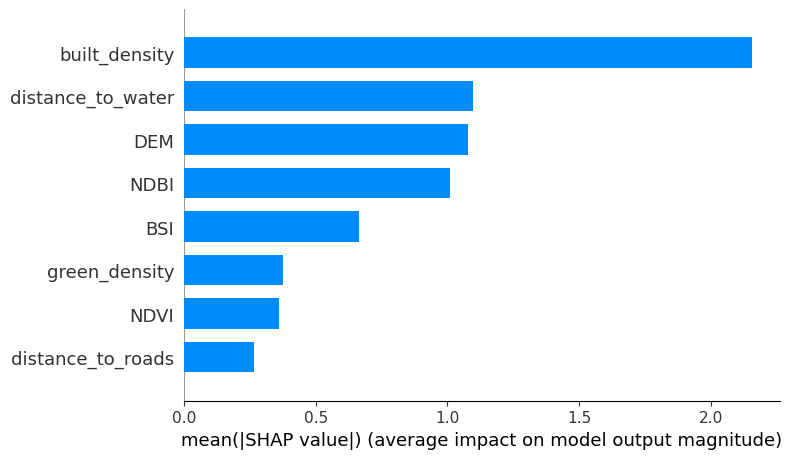


✓ SHAP analysis complete for XGBoost


In [18]:
# ---------------------------------------------------------------------
# STEP 14 — FEATURE IMPORTANCE AND INTERPRETATION USING SHAP
# Explains which environmental variables most influence hotspot prediction
# ---------------------------------------------------------------------

print("\n--- STEP 13: SHAP FEATURE IMPORTANCE ---\n")

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=df.drop(columns="label").columns,
    plot_type="bar"
)
print("\n✓ SHAP analysis complete for XGBoost")

In [19]:
# ---------------------------------------------------------------------
# STEP 15 — APPLY BEST MODEL TO FULL STUDY AREA
# Predict hotspot occurrence for every pixel in the raster
# ---------------------------------------------------------------------
print("\n--- STEP 14: FULL MAP PREDICTION (XGBoost) ---\n")

# Use the same predictor structure used during training
# IMPORTANT: must match training features exactly
X_full = X_2d[:, :8]

print("Full feature matrix shape:", X_full.shape)

# Predict binary hotspot classification for every pixel
pred_full = xgb_model.predict(X_full)

# Reshape back to raster dimensions
pred_map = pred_full.reshape(rows, cols)

print("Prediction map created")
print("Map shape:", pred_map.shape)


--- STEP 14: FULL MAP PREDICTION (XGBoost) ---

Full feature matrix shape: (883972, 8)
Prediction map created
Map shape: (892, 991)


In [20]:
# ---------------------------------------------------------------------
# STEP 16 — CREATE HOTSPOT PROBABILITY MAP
# More informative than binary classification
# Shows confidence of hotspot prediction
# ---------------------------------------------------------------------
print("\n--- STEP 15: PROBABILITY MAP ---\n")

prob_full = xgb_model.predict_proba(X_full)[:, 1]  # probability of class = 1
prob_map = prob_full.reshape(rows, cols)

print("Probability map created")
print("Probability range:", prob_full.min(), "to", prob_full.max())


--- STEP 15: PROBABILITY MAP ---

Probability map created
Probability range: 9.656038e-12 to 0.9999989


In [21]:
# ---------------------------------------------------------------------
# STEP 17 — SAVE OUTPUT RASTERS (GeoTIFF)
# Produces publication-ready spatial products
# ---------------------------------------------------------------------
print("\n--- STEP 16: SAVING OUTPUT MAPS ---\n")


# Use original raster metadata as template
meta = stack_src.meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

# Save binary hotspot map
hotspot_out = STACK_PATH.replace("predictor_stack", "predicted_hotspots")
with rasterio.open(hotspot_out, "w", **meta) as dst:
    dst.write(pred_map.astype("float32"), 1)

print("✓ Binary hotspot map saved:", hotspot_out)

# Save probability map
prob_out = STACK_PATH.replace("predictor_stack", "hotspot_probability")
with rasterio.open(prob_out, "w", **meta) as dst:
    dst.write(prob_map.astype("float32"), 1)

print("✓ Probability map saved:", prob_out)




--- STEP 16: SAVING OUTPUT MAPS ---

✓ Binary hotspot map saved: /Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_predicted_hotspots.tif
✓ Probability map saved: /Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_hotspot_probability.tif



--- STEP 17: SHAP INTERPRETATION ---



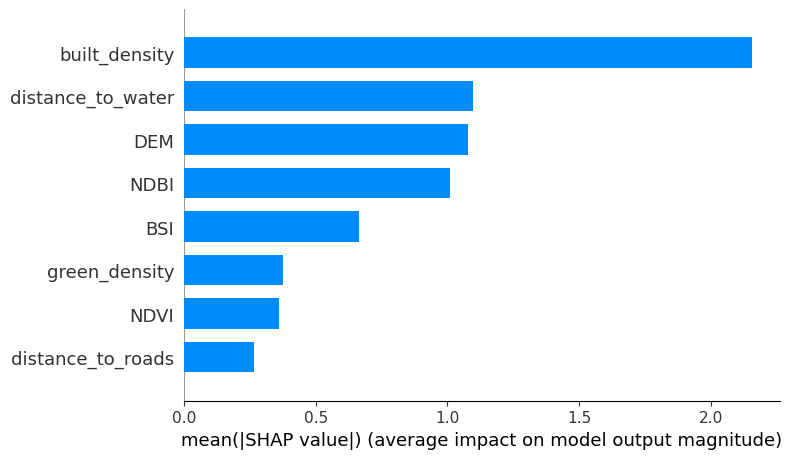

✓ SHAP global importance computed


In [22]:
# ---------------------------------------------------------------------
# STEP 18 — GLOBAL FEATURE IMPORTANCE USING SHAP
# Identifies key drivers of hotspot formation
# ---------------------------------------------------------------------
print("\n--- STEP 17: SHAP INTERPRETATION ---\n")


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Bar plot: clean and publication-friendly
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=df.drop(columns="label").columns,
    plot_type="bar"
)

print("✓ SHAP global importance computed")




--- STEP 18: SHAP DISTRIBUTION PLOT ---



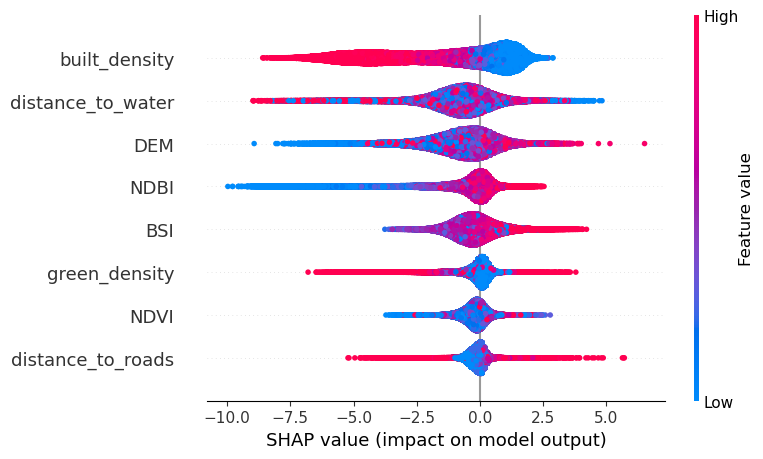

✓ SHAP distribution plot generated


In [23]:
# ---------------------------------------------------------------------
# STEP 19 — DETAILED SHAP DISTRIBUTION PLOT
# Shows direction of influence of each variable
# ---------------------------------------------------------------------
print("\n--- STEP 18: SHAP DISTRIBUTION PLOT ---\n")

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=df.drop(columns="label").columns
)

print("✓ SHAP distribution plot generated")


--- STEP 17B: SUSCEPTIBILITY MAP VISUALIZATION ---



/var/folders/zh/vv_ph5h91yzf_q6cpgm75d1c0000gn/T/ipykernel_27089/2383156092.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


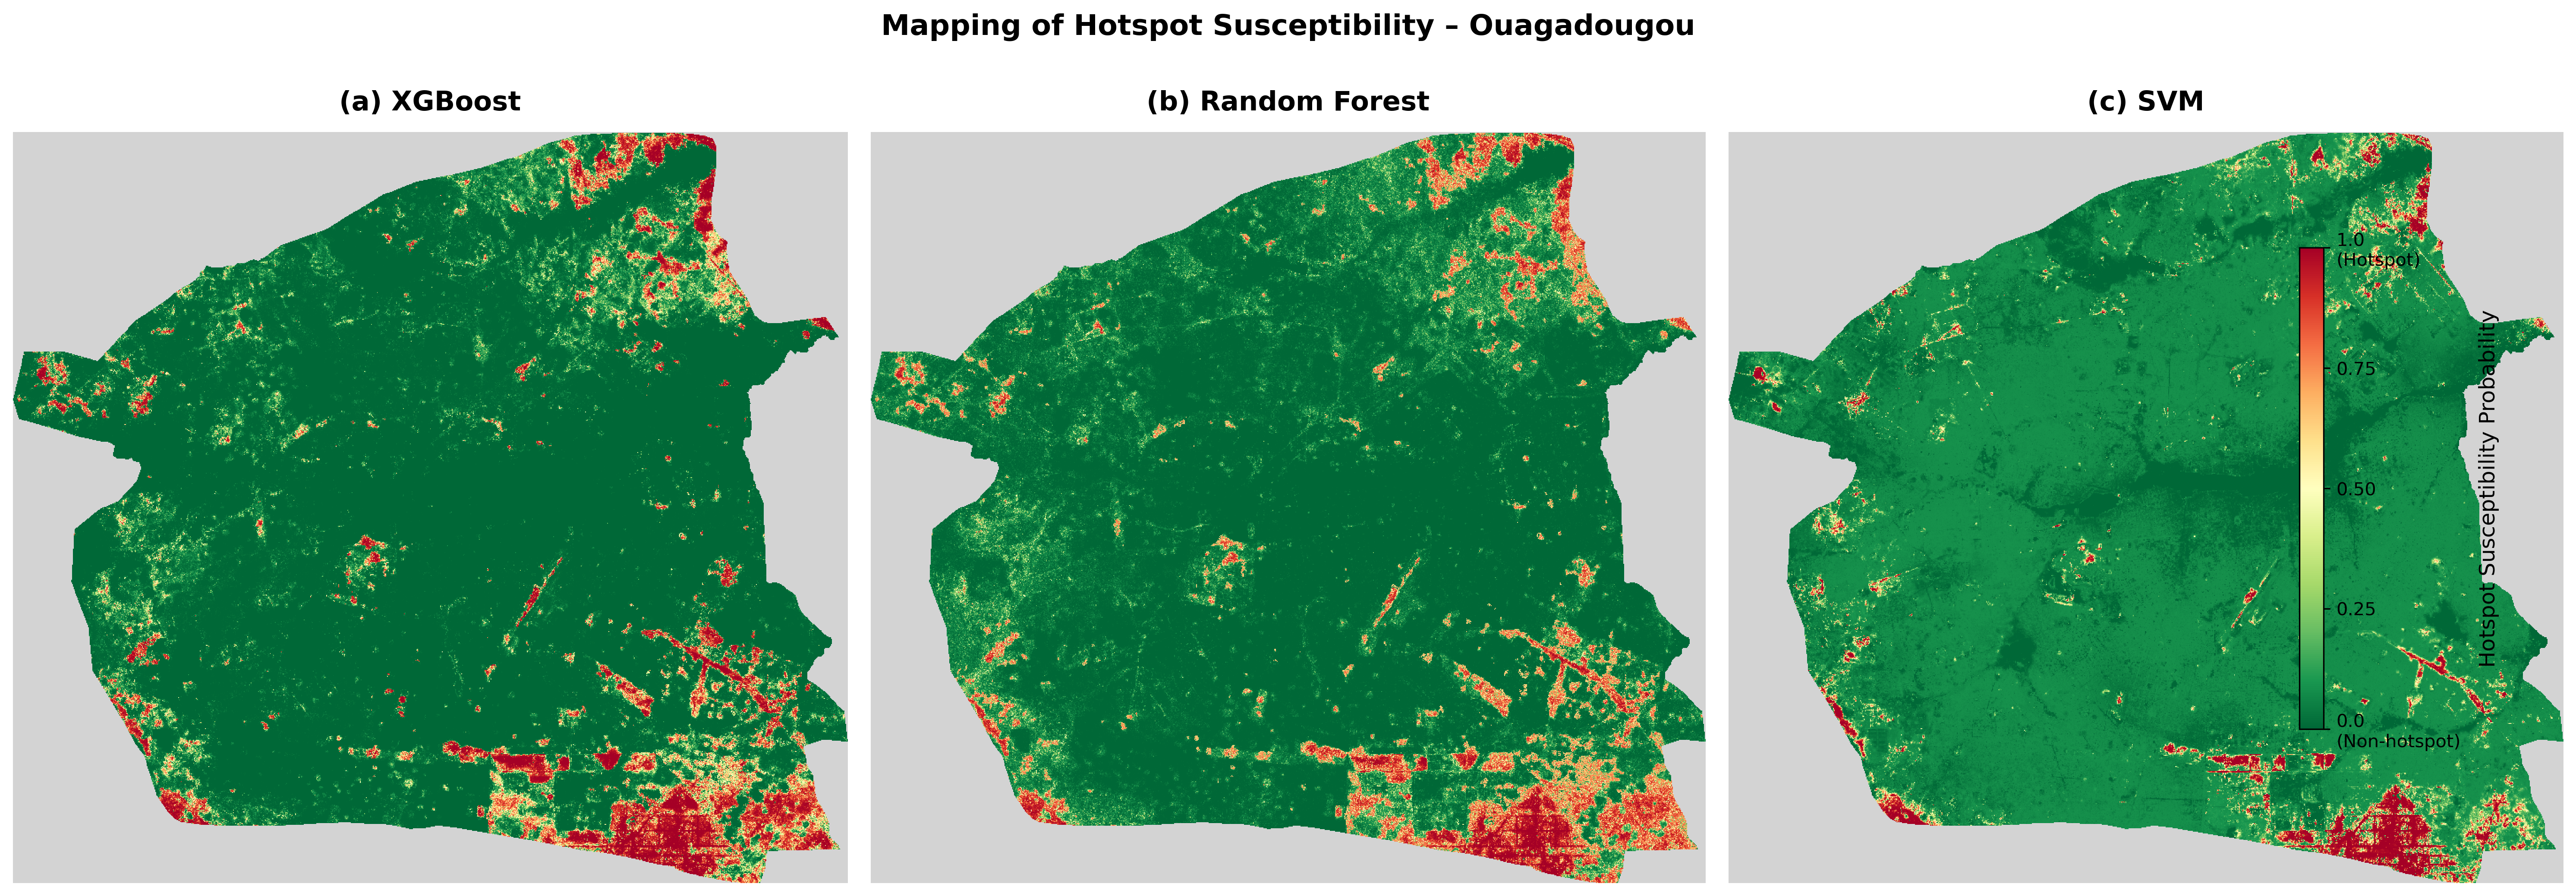

✓ Figure 7 (susceptibility maps) saved: /Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_fig7_susceptibility_maps.png


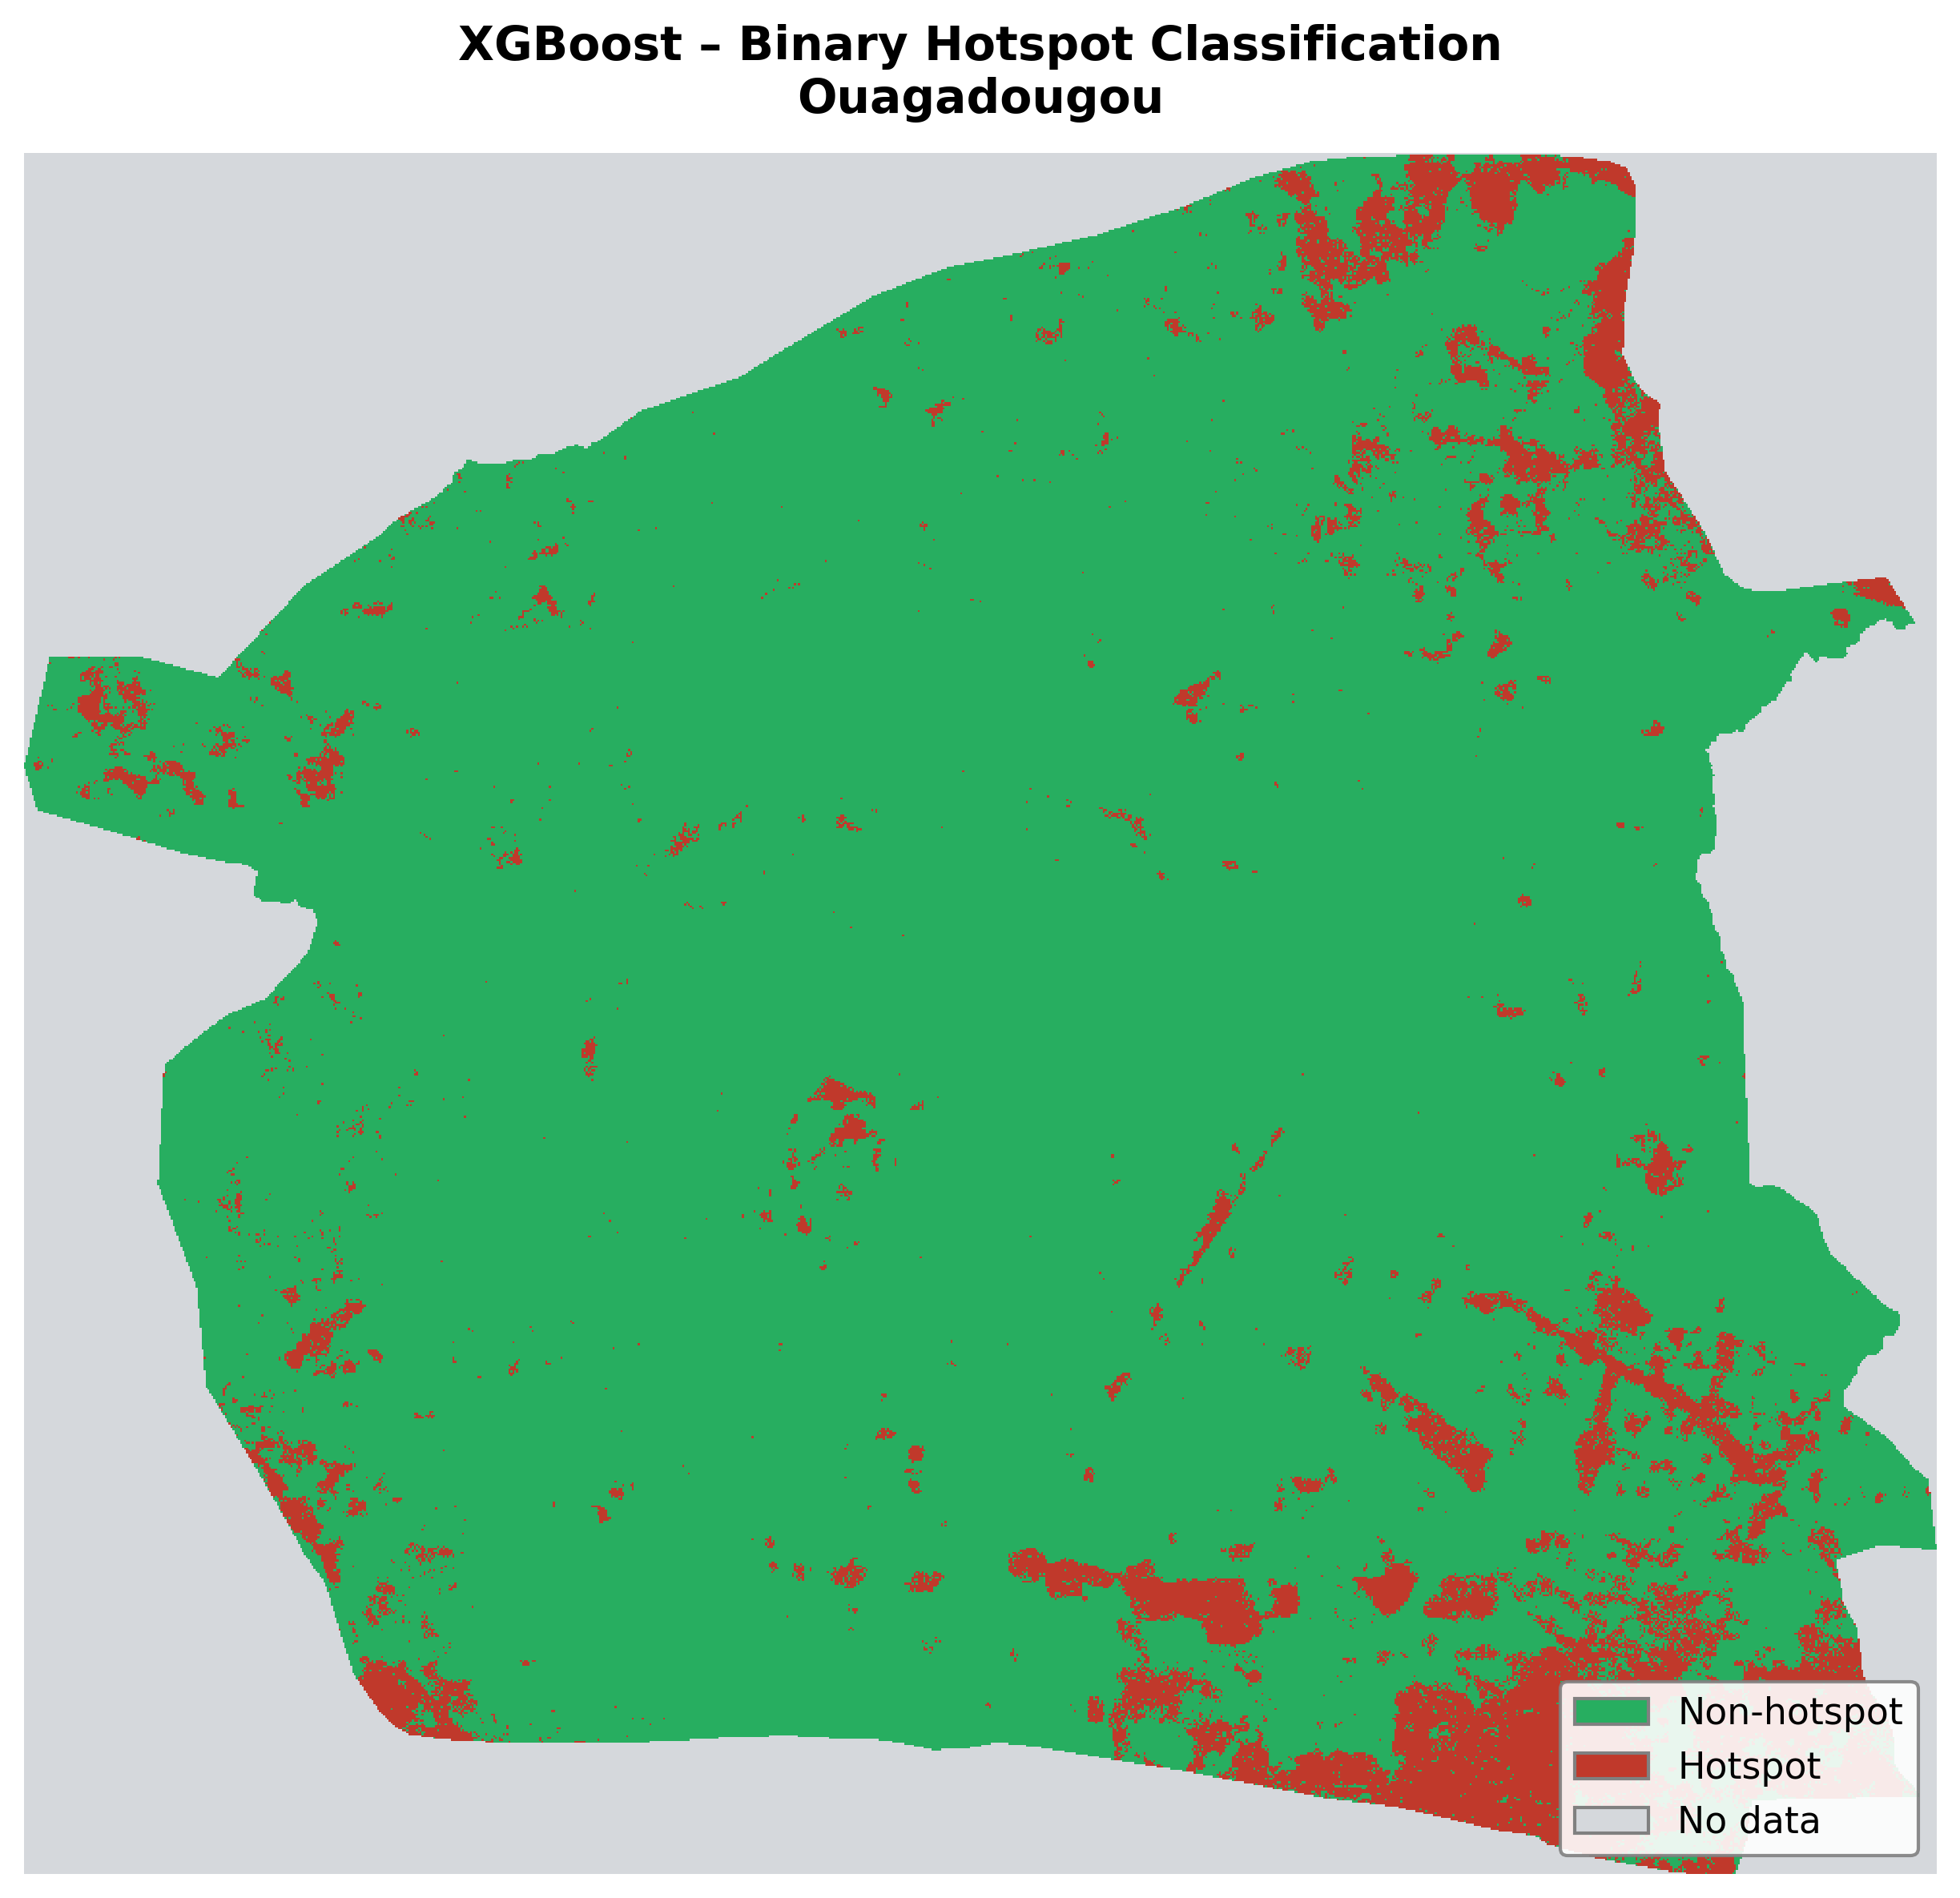

✓ Binary hotspot map saved: /Users/elindner/Documents/Climatematch/Hotspotters/processed/ouaga_fig_binary_hotspot.png


In [24]:
# ---------------------------------------------------------------------
# STEP 20 — PUBLICATION-QUALITY SUSCEPTIBILITY MAPS
# Matches paper Figure 7: XGBoost, RF, SVM side by side
# Output: inline + saved PNG (300 DPI)
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np

print("\n--- STEP 17B: SUSCEPTIBILITY MAP VISUALIZATION ---\n")

# --- Generate probability maps for all models ---
prob_xgb = xgb_model.predict_proba(X_full)[:, 1].reshape(rows, cols)
prob_rf  = rf_model.predict_proba(X_full)[:, 1].reshape(rows, cols)

# SVM requires special handling for NaN values
try:
    # Create a mask for valid (non-NaN) pixels
    valid_full_mask = ~np.isnan(X_full).any(axis=1)
    
    # Initialize with NaNs
    prob_svm_flat = np.full(X_full.shape[0], np.nan)
    
    # Only predict on valid pixels
    if valid_full_mask.sum() > 0:
        prob_svm_flat[valid_full_mask] = svm_model.predict_proba(X_full[valid_full_mask])[:, 1]
    
    # Reshape to map
    prob_svm = prob_svm_flat.reshape(rows, cols)
    
except AttributeError:
    print("⚠ SVM probability not available - using binary predictions instead")
    print("  → Add probability=True to SVC() and retrain to fix this")
    
    # Same NaN handling for binary predictions
    valid_full_mask = ~np.isnan(X_full).any(axis=1)
    prob_svm_flat = np.full(X_full.shape[0], np.nan)
    if valid_full_mask.sum() > 0:
        prob_svm_flat[valid_full_mask] = svm_model.predict(X_full[valid_full_mask]).astype(float)
    prob_svm = prob_svm_flat.reshape(rows, cols)
# Binary XGBoost prediction
pred_xgb_binary = xgb_model.predict(X_full).reshape(rows, cols)

# --- NaN mask (outside study area) ---
nan_mask = np.isnan(y)  # from original label raster

def apply_nan_mask(arr, mask):
    arr_masked = arr.astype(float).copy()
    arr_masked[mask] = np.nan
    return arr_masked

prob_xgb_masked    = apply_nan_mask(prob_xgb, nan_mask)
prob_rf_masked     = apply_nan_mask(prob_rf,  nan_mask)
prob_svm_masked    = apply_nan_mask(prob_svm, nan_mask)
pred_binary_masked = apply_nan_mask(pred_xgb_binary, nan_mask)

# --- Colormap: matches paper Figure 7 style ---
# Cool-warm: blue/green = non-hotspot, red = hotspot
cmap_prob = plt.cm.RdYlGn_r
cmap_prob.set_bad(color='lightgrey')

# =============================================================
# FIGURE 1: Side-by-side probability maps (paper Figure 7)
# =============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 7), dpi=300)

maps   = [prob_xgb_masked, prob_rf_masked, prob_svm_masked]
titles = ['(a) XGBoost', '(b) Random Forest', '(c) SVM']

for ax, data, title in zip(axes, maps, titles):
    im = ax.imshow(
        data,
        cmap=cmap_prob,
        vmin=0, vmax=1,
        interpolation='none'
    )
    ax.set_title(title, fontsize=15, fontweight='bold', pad=12)
    ax.axis('off')

# Shared vertical colorbar
cbar = fig.colorbar(
    im,
    ax=axes.tolist(),
    orientation='vertical',
    fraction=0.012,
    pad=0.02,
    shrink=0.75
)
cbar.set_label('Hotspot Susceptibility Probability', fontsize=12, labelpad=10)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels(['0.0\n(Non-hotspot)', '0.25', '0.50', '0.75', '1.0\n(Hotspot)'], fontsize=10)

fig.suptitle(
    'Mapping of Hotspot Susceptibility – Ouagadougou',
    fontsize=16, fontweight='bold', y=1.02
)

plt.tight_layout()

# Save
prob_map_path = STACK_PATH.replace("predictor_stack", "fig7_susceptibility_maps").replace(".tif", ".png")
plt.savefig(prob_map_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Figure 7 (susceptibility maps) saved: {prob_map_path}")


# =============================================================
# FIGURE 2: Binary hotspot map – XGBoost only
# =============================================================
fig2, ax2 = plt.subplots(1, 1, figsize=(9, 8), dpi=300)

# Two-color: green = non-hotspot, red = hotspot
cmap_binary = mcolors.ListedColormap(['#27ae60', '#c0392b'])
bounds = [-0.5, 0.5, 1.5]
norm   = mcolors.BoundaryNorm(bounds, cmap_binary.N)
cmap_binary.set_bad(color='#d5d8dc')  # grey for NaN

ax2.imshow(
    pred_binary_masked,
    cmap=cmap_binary,
    norm=norm,
    interpolation='none'
)

ax2.set_title(
    'XGBoost – Binary Hotspot Classification\nOuagadougou',
    fontsize=14, fontweight='bold', pad=12
)
ax2.axis('off')

# Legend
legend_elements = [
    Patch(facecolor='#27ae60', edgecolor='grey', label='Non-hotspot'),
    Patch(facecolor='#c0392b', edgecolor='grey', label='Hotspot'),
    Patch(facecolor='#d5d8dc', edgecolor='grey', label='No data'),
]
ax2.legend(
    handles=legend_elements,
    loc='lower right',
    fontsize=11,
    framealpha=0.9,
    edgecolor='grey'
)

plt.tight_layout()

# Save
binary_map_path = STACK_PATH.replace("predictor_stack", "fig_binary_hotspot").replace(".tif", ".png")
plt.savefig(binary_map_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✓ Binary hotspot map saved: {binary_map_path}")